In [75]:
import pandas as pd
from pandasql import sqldf 
import numpy as np
import matplotlib.pyplot as plt



In [76]:
sql = lambda q: sqldf(q, globals())
df = pd.read_csv("athlete_events.csv")
df.columns

Index(['ID', 'Name', 'Sex', 'Age', 'Height', 'Weight', 'Team', 'NOC', 'Games',
       'Year', 'Season', 'City', 'Sport', 'Event', 'Medal'],
      dtype='object')

In [77]:
def fun(bbd):
    qry =sql('''
    SELECT
    *
    FROM  df
    LIMIT 5
    '''.format(df = varname(bbd)))
    return qry

In [78]:
def clean(bbd:str,columns:list):
    qry = sql('''
    SELECT
    {1}
    FROM {0}
    '''.format(bbd,str(columns)[1:-1].replace("'" , "")))
    return qry

In [79]:
columns = 'ID','Sex','Age','Height','Weight','Team','Year','Season','City','Sport'
newdf = clean('df',columns)
newdf = newdf.dropna(subset=['Age','Height','Weight'])
newdf.Team= newdf.Team.str.replace('[\d+\W]','', regex=True)

In [80]:
def sex(bbd, columns:list, sex:str):
    qry = sql('''
    SELECT
    {1}
    FROM {0}
    WHERE Sex = "{2}"
    '''.format(bbd,str(columns)[1:-1].replace("'" , ""), sex))
    return qry

In [81]:
Male = sex('newdf',columns,'M')
Female = sex('newdf', columns, 'F')
print(' Shape Male DataFrame {} \n Shape Female DataFrame {}'.format(Male.shape, Female.shape))

 Shape Male DataFrame (139454, 10) 
 Shape Female DataFrame (66711, 10)


### Male

In [82]:
def Count(bbd:str, column:str):
    qry= sql('''
    SELECT
    {1},
    COUNT({1}) as count
    FROM {0}
    GROUP BY {1}
    '''.format(bbd,column))
    return qry

In [83]:
countageM = Count('Male','Age')
countageF = Count('Female','Age')
count = pd.concat([countageM,countageF],keys=['Male','Female']).droplevel(level=1)
count.sort_values(by='Age', ascending=False)

,Age,count
Male,71.0,1
Male,70.0,2
Female,69.0,2
Male,68.0,1
Male,67.0,2
...,...,...
Female,13.0,133
Male,13.0,28
Female,12.0,24
Male,12.0,3


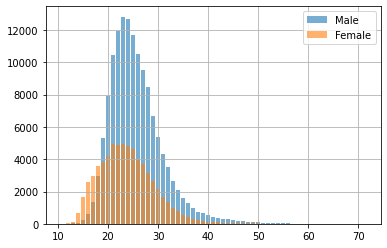

In [84]:
fig, ax = plt.subplots()
M = ax.bar(countageM['Age'],countageM['count'], label='Male', alpha=0.6)
F = ax.bar(countageF['Age'], countageF['count'], label='Female', alpha=0.6)
ax.legend()
plt.grid()
plt.show()

In [85]:
def stast(bbd:str, column, sex:str):
    qry=sql('''
    SELECT
    min({1}) as min,
    ROUND(avg({1}),2) as avg,
    max({1}) as max
    FROM {0}
    '''.format(bbd, column,sex))
    return qry

In [86]:
stastM = stast('countageM','Age','Male')
stastF = stast('countageF', 'Age','Female')
summary = pd.concat([stastM,stastF],keys=['Male','Female']).droplevel(level=1)
summary

,min,avg,max
Male,12.0,41.03,71.0
Female,11.0,38.22,69.0


In [87]:
def stastplot(df:pd.DataFrame):
    
    assert type(df) == pd.DataFrame, "First parameter should be a DataFrame"
    
    x = np.arange(len(df.iloc[0].index))
    width = 0.2
    for i in range(0,len(summary),1):
        if i <= 0:
            plt.bar(x , df.iloc[i], width=0.2, label='Male',alpha=0.6)
        else:
            plt.bar(x + (width*1), df.iloc[i],width=0.2, label='Female',alpha=0.6)
    plt.xticks(x, ['min','avg','max'], horizontalalignment="left")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()
    

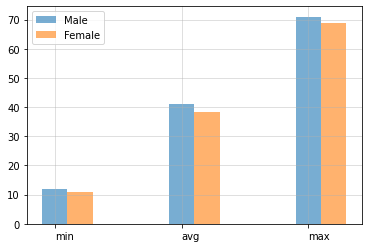

In [88]:
stastplot(summary)

In [89]:
Male.head()

,ID,Sex,Age,Height,Weight,Team,Year,Season,City,Sport
0,1,M,24.0,180.0,80.0,China,1992,Summer,Barcelona,Basketball
1,2,M,23.0,170.0,60.0,China,2012,Summer,London,Judo
2,6,M,31.0,188.0,75.0,UnitedStates,1992,Winter,Albertville,Cross Country Skiing
3,6,M,31.0,188.0,75.0,UnitedStates,1992,Winter,Albertville,Cross Country Skiing
4,6,M,31.0,188.0,75.0,UnitedStates,1992,Winter,Albertville,Cross Country Skiing


In [90]:
def team(bdd, groupby:str, orderby:str):
    qry = sql('''
    SELECT
    Team,
    Count({count}) as count
    FROM {df}
    Group by {group}
    Order by {order} desc
    '''.format(count = 'ID', df=bdd, group=groupby,order=orderby))
    return qry


In [91]:
M = team('Male','Team','count')
F = team('Female','Team','count')

In [93]:
def joinMF():
    qry = sql('''
    -- METRICS
    SELECT
    Team,
    Mcount,
    Fcount,
    (Mcount - Fcount) as diference,
    ROUND(CAST(Mcount as float) / CAST(Fcount as float),2)  as div
    FROM
    (-- FILL VALUE WITH 0 WHERE FCOUNT IS NAN
    SELECT
    Team,
    Mcount,
    COALESCE(Fcount,0) as Fcount
    FROM 
    ( -- JOIN TABLE M,F
    SELECT
    M.Team,
    M.count as Mcount,
    F.count as Fcount
    FROM M 
    LEFT JOIN F
    ON M.Team = F.Team))
    ''')
    return qry



In [95]:
joinMF = joinMF()
joinMF = joinMF[~joinMF['div'].isnull()]

In [96]:
joinMF50 = joinMF.head(50)
joinMF50 = joinMF50.sort_values(by='div', ascending=False)

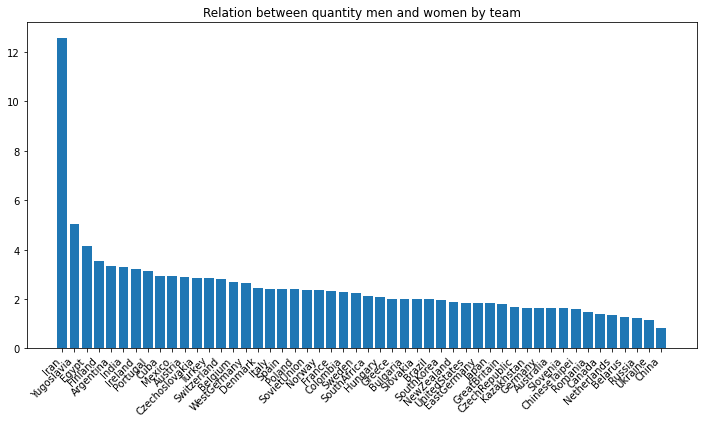

In [99]:
plt.figure(figsize=(12,6))
plt.bar(joinMF50['Team'],joinMF50['div'])
plt.xticks(rotation=45,horizontalalignment="right")
plt.title("Relation between quantity men and women by team")
plt.show()

In [110]:
teamByYear = pd.DataFrame(Male.groupby(['Team','Year']).count()['ID'])
teamByYear.head()

ID
Team        Year    
Acipactli   1964   3
Afghanistan 1960  16
            1964   2
            1968   5
            1972   3

In [113]:
def teambyyear(df:str):    
    qry = sql('''
    SELECT
    Team,
    Year,
    Count('ID') as count{0}
    FROM {0}
    Group by Team,Year
    '''.format(df))
    return qry


In [116]:
M = teambyyear('Male')
F = teambyyear('Female')

In [134]:
testM = M[M['Team'] == 'Iran'] 
testF = F[F['Team'] == 'Iran']


In [147]:
def country(country:str, team='Team'):
    Male =M[M[team] ==country]
    Fem = F[F[team] == country]
    merge = Male.merge(Fem, on='Year', how='left')
    merge = merge.fillna(0)
    merge = merge.drop(['Team_y'],axis=1)
    merge.columns = ['Country','Year','Male','Female']
    return merge

In [211]:
def teambycountry(country):
    qry=sql('''
    SELECT
    Team,
    Year,
    Male,
    COALESCE(Female,0) as Female
    FROM (
    -- SELECT COLUMNS
    SELECT
    M.Team,
    M.Year,
    M.countMale as Male,
    F.countFemale as Female
    FROM
    -- JOIN M with F
    (SELECT
    *
    FROM M
    WHERE Team = "{0}") as M
    LEFT  JOIN (
    -- DATASET FEMALE
    SELECT
    *
    FROM F
    WHERE Team ="{0}") as F
    ON M.Year = F.Year)
    '''.format(country))
    return qry

In [227]:
def barplot(df):
    country = teambycountry(df)
    plt.figure(figsize=(12,6))
    width = 2
    plt.bar(country.Year, country['Male'], width=width)
    plt.bar(country.Year, country['Female'],width=width)
    plt.title('{}'.format(df))
    plt.show

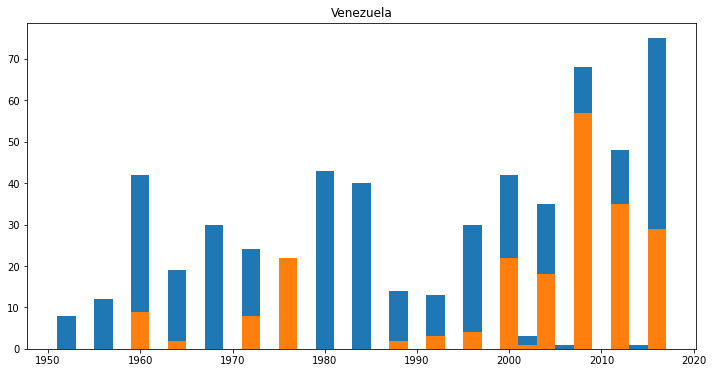

In [230]:
barplot('Venezuela')